In [2]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import iecdt_lab

In [3]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import tqdm
import numpy as np

In [4]:
TILES_FILE = "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_numpy"
TEST_METADATA = "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_time_test.csv"
TILES_STATISTICS = "/gws/nopw/j04/iecdt/deep_learning_lab/1km_naturalcolor_metadata_rgb_stats.npz"

# Compute ResNet Embeddings

In [ ]:
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid(),  # Ensure that output lies between 0 and 1.
)
# If you want to load a model that you have trained use:
# model.load_state_dict(torch.load("path/to/experiment/model.pth"))
model.eval()

In [5]:
data_stats = np.load(TILES_STATISTICS)
data_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=data_stats["rgb_mean"], std=data_stats["rgb_std"]
        ),
    ]
)
test_ds = iecdt_lab.data_loader.GOESRGBTiles(
    tiles_file=TILES_FILE,
    metadata_file=TEST_METADATA,
    transform=data_transforms,
)
test_data_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=64,
    shuffle=True,
    num_workers=16,
)

In [7]:
print(f"Dataset size: {len(test_ds)}")

tile, labels = test_ds[0]

print(f"Tile shape: {tile.shape}")
print(f"Labels: {labels}") 

Dataset size: 3696
Tile shape: torch.Size([3, 256, 256])
Labels: (11.149859717850656, 0.3623199462890625, 0.6002626072876222, 1.7299827538606949)


Sample Labels:
- Mean Cloud Lengthscale: 11.1499
- Cloud Fraction: 0.3623
- Cloud IORG: 0.6003
- Fractal Dimension: 1.7300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2925463..2.4427025].


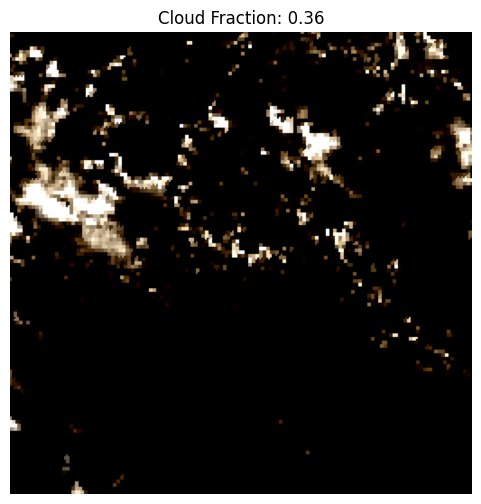

In [8]:
if isinstance(tile, torch.Tensor):
    tile = tile.numpy().transpose(1, 2, 0)  # Convert (C, H, W) → (H, W, C) for visualization

label_names = ["Mean Cloud Lengthscale", "Cloud Fraction", "Cloud IORG", "Fractal Dimension"]

print("Sample Labels:")
for name, value in zip(label_names, labels):
    print(f"- {name}: {value:.4f}")

plt.figure(figsize=(6, 6))
plt.imshow(tile) 
plt.title(f"Cloud Fraction: {labels[1]:.2f}") 
plt.axis("off")
plt.show()

Remove the last layer of the ResNet so the model outputs the embeddings before the final layer.

In [ ]:
embedding_model = torch.nn.Sequential(*list(model.children())[:-1])
embedding_model.eval()

Compute the actual embeddings for all of the test dataset. This cell will take a couple of minutes to run!

In [ ]:
embeddings = []
for batch, labels in tqdm.tqdm(test_data_loader):
    with torch.no_grad():
        embeddings.append(embedding_model(batch).numpy())
embeddings = np.concatenate(embeddings, axis=0)
embeddings = embeddings.reshape(embeddings.shape[0], -1)

In [ ]:
embeddings.shape

# Cluster the Embeddings

In [14]:
def plot_cluster_tiles(cluster_labels, tile_dataset, num_samples=5) -> plt.Figure:
    """Plot the clusters of the test tiles. Each column is a cluster."""
    num_clusters = len(np.unique(cluster_labels))
    fig, axs = plt.subplots(
        num_samples, num_clusters, figsize=(num_clusters * 2, num_samples * 2)
    )
    for i in range(num_clusters):
        cluster_ixs = np.where(cluster_labels == i)[0]
        for j in range(num_samples):
            if j < len(cluster_ixs):
                tile, _ = tile_dataset[cluster_ixs[j]]
                axs[j, i].imshow(tile)
            axs[j, i].axis("off")

        axs[0, i].set_title(f"Cluster {i}")

    fig.tight_layout()
    return fig

def plot_clusters(cluster_labels, pca_embeddings) -> plt.Figure:
    """Plot the clusters in the PCA space."""
    fig, ax = plt.subplots(figsize=(8, 8))
    for i in np.unique(cluster_labels):
        cluster_ixs = np.where(cluster_labels == i)[0]
        ax.scatter(
            pca_embeddings[cluster_ixs, 0],
            pca_embeddings[cluster_ixs, 1],
            label=f"Cluster {i}",
        )
    ax.legend()
    return fig

To get some understanding of how the embedding space is structured we will first reduce the embedding dimensionality using principal component analysis (PCA) and then cluster using KMeans. Feel free to experiment with different dimensionality reduction methods and clustering algorithms!

In [17]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

kmeans = KMeans(n_clusters=10, random_state=0).fit(pca_embeddings)
cluster_labels = kmeans.predict(pca_embeddings)

In [ ]:
_ = plot_clusters(cluster_labels, pca_embeddings)

In [ ]:
test_ds_no_transform = iecdt_lab.data_loader.GOESRGBTiles(
    tiles_file=TILES_FILE,
    metadata_file=TEST_METADATA,
)

In [ ]:
_ = plot_cluster_tiles(cluster_labels, test_ds_no_transform, num_samples=5)